In [183]:
import pandas as pd
import numpy as np

# Talent Migration in Algeria

The data and methodology used in this notebook are a product [World Bank research in collaboration with LinkedIn](https://documents1.worldbank.org/curated/en/827991542143093021/pdf/World-Bank-Group-LinkedIn-Data-Insights-Jobs-Skills-and-Migration-Trends-Methodology-and-Validation-Results.pdf)

In [184]:
country_migration = pd.read_csv('../../data/LinkedIn/country_migration_official_use.csv')
industry_migration = pd.read_csv('../../data/LinkedIn/industry_migration_official_use.csv')
skills_migration = pd.read_csv('../../data/LinkedIn/skill_migration_official_use.csv')
#linkedin_migration = pd.read_excel('../../data/LinkedIn/Public Use_LinkedIn Migration Data.xlsx', sheet_name=')

In [185]:
country_flows = pd.read_excel('../../data/LinkedIn/Public Use_LinkedIn Migration Data.xlsx', sheet_name='1. country_inflow_outflow')
country_industry_flow = pd.read_excel('../../data/LinkedIn/Public Use_LinkedIn Migration Data.xlsx', sheet_name='2. country_inflow_outflow_ind')
country_skill_flow = pd.read_excel('../../data/LinkedIn/Public Use_LinkedIn Migration Data.xlsx', sheet_name='3. country_inflow_outflow_skill')

pairwise_skill_migration = pd.read_excel('../../data/LinkedIn/Public Use_LinkedIn Migration Data.xlsx', sheet_name = '6. pairwise_flows_skill')
pairwise_industry_migration = pd.read_excel('../../data/LinkedIn/Public Use_LinkedIn Migration Data.xlsx', sheet_name = '5. pairwise_flows_ind')
pairwise_country_migration = pd.read_excel('../../data/LinkedIn/Public Use_LinkedIn Migration Data.xlsx', sheet_name = '4. pairwise_flows')

In [186]:
countries_of_interest = ['Algeria']
regional_peers = ['Egypt', 'Iraq', 'Jordan', 'Morocco', 'Tunisia']
structural_peers = ['Uzbekistan', 'Ecuador', 'Peru', 'Ghana', 'Vietnam', 'Colombia']
aspirational_peers = ['Chile', 'Kazakhstan', 'Malaysia', 'Poland', 'Romania', 'Turkey']


## Country Industry Size Location Quotient


LQ = (Country Industry Size) / (Income Group Average Industry Size)

### Methodology
**Step 1**: Calculate Country Industry Size

Country Industry Size = (Employment in Industry i in Country c) / (Total Employment in Country c)

**Step 2**: Calculate Income Group Average Industry Size

Income Group Average = Σ(Country Industry Size for all countries in income group) / Number of countries in income group

**Step 3**: Calculate Location Quotient
LQ = (Country Industry Size) / (Income Group Average Industry Size)

For country c, industry i, and income group I:
LQ(c,i) = [e(c,i) / e(c,total)] / [Σ(e(k,i) / e(k,total)) / n]
Where:

e(c,i) = Employment in industry i in country c
e(c,total) = Total employment in country c
k = Each country in the same income group as country c
n = Number of countries in the income group
Σ = Sum across all countries in the income group

Alternative Compact Form
LQ(c,i) = (e(c,i) / e(c,total)) / (1/n × Σ[e(k,i) / e(k,total)])
Interpretation

- LQ > 1: Country has higher concentration in this industry compared to income group peers
- LQ = 1: Country matches the income group average
- LQ < 1: Country has lower concentration compared to income group peers

**Notes**

- Unweighted Average: Each country in the income group is treated as one observation regardless of country size
- Income Group Benchmark: Countries are compared against peers at similar development levels, not global averages
- Relative Measure: LQ shows relative specialization, not absolute employment levels

In [187]:
peers_in_income_group = industry_migration[(industry_migration['wb_income']=='Upper middle income')&(industry_migration['country_name'].isin(countries_of_interest+regional_peers+structural_peers+aspirational_peers))][['country_name', 'wb_income']].drop_duplicates()['country_name'].tolist()

In [188]:
def calculate_location_quotient(df: pd.DataFrame, level: str = 'industry') :
    """
    Calculates the Location Quotient (LQ) for each country and industry/section across multiple years
    using World Bank methodology (income group benchmark).

    The Location Quotient formula is:
    LQ = (Country industry size) / (Income group average industry size)
    
    Where:
    - Country industry size = (employment in industry i in country c) / (total employment in country c)
    - Income group average = arithmetic mean of industry sizes across all countries in the same income group
      (each country treated as one observation regardless of size)

    Args:
        df (pd.DataFrame): DataFrame with columns for country, industry, wb_income and
                           yearly employment counts (e.g., 'total_member_cnt_YYYY').
        level (str): Level of aggregation - either 'industry' or 'section'.
                     Defaults to 'industry'.

    Returns:
        pd.DataFrame: A DataFrame with the original identifiers plus the
                      year, employment count, and calculated LQ for each row.
    """
    if level not in ['industry', 'section']:
        raise ValueError("Level must be either 'industry' or 'section'")
    
    # 1. Reshape data from wide to long format
    id_cols = [
        'country_code', 'country_name', 'wb_income', 'wb_region',
        'isic_section_index', 'isic_section_name', 'industry_id', 'industry_name'
    ]
    value_cols = [col for col in df.columns if 'total_member_cnt_' in col]
    
    if not value_cols:
        raise ValueError("No 'total_member_cnt_YYYY' columns found in the DataFrame.")

    long_df = pd.melt(
        df,
        id_vars=id_cols,
        value_vars=value_cols,
        var_name='year',
        value_name='employment'
    )

    # Clean up the 'year' column to be an integer
    long_df['year'] = long_df['year'].str.extract(r'(\d{4})').astype(int)

    # For robustness, fill any potential NaN employment values with 0
    long_df['employment'] = long_df['employment'].fillna(0)

    # 2. Aggregate data based on chosen level
    if level == 'section':
        # Aggregate employment at ISIC section level
        aggregation_cols = ['country_code', 'country_name', 'wb_income', 'wb_region',
                           'isic_section_index', 'isic_section_name', 'year']
        
        long_df = long_df.groupby(aggregation_cols)['employment'].sum().reset_index()
        
        # Set the grouping variables for LQ calculation
        industry_group_col = 'isic_section_index'
        output_id_cols = aggregation_cols
        
    else:  # level == 'industry'
        # Keep original industry-level data
        aggregation_cols = ['country_code', 'country_name', 'wb_income', 'wb_region',
                           'isic_section_index', 'isic_section_name','industry_name', 'industry_id', 'year']
        
        long_df = long_df.groupby(aggregation_cols)['employment'].sum().reset_index()

        industry_group_col = 'industry_id'
        output_id_cols = aggregation_cols

    # 3. Calculate country industry size (Step 1 from WB methodology)
    # Country industry size = employment in industry i / total employment in country
    long_df['country_total_employment'] = long_df.groupby(['country_code', 'year'])['employment'].transform('sum')
    long_df['country_industry_size'] = long_df['employment'] / long_df['country_total_employment']
    
    # Handle division by zero (countries with no employment)
    long_df['country_industry_size'] = long_df['country_industry_size'].fillna(0)

    # 4. Calculate income group average industry size (Step 2 from WB methodology)
    # Arithmetic mean of industry sizes across countries in same income group
    # Each country treated as one observation regardless of country size
    long_df['income_group_avg_industry_size'] = long_df.groupby(['wb_income', industry_group_col, 'year'])['country_industry_size'].transform('mean')

    # 5. Calculate Location Quotient
    # LQ = Country industry size / Income group average industry size
    long_df['lq'] = long_df['country_industry_size'] / long_df['income_group_avg_industry_size']
    
    # Handle division by zero and infinite values
    long_df['lq'] = long_df['lq'].replace([np.inf, -np.inf], 0).fillna(0)
    
    # Select and reorder columns for a clean output
    final_output_cols = output_id_cols + ['employment', 'country_industry_size', 'income_group_avg_industry_size', 'lq']
    
    return long_df[final_output_cols]

In [189]:
industry_count = industry_migration[['country_code', 'country_name', 'wb_income', 'wb_region',
       'isic_section_index', 'isic_section_name', 'industry_id',
       'industry_name', 'total_member_cnt_2015', 'total_member_cnt_2016','total_member_cnt_2017',
       'total_member_cnt_2018', 'total_member_cnt_2019']].drop_duplicates()

#industry_count = industry_count[industry_count['country_name'].isin(countries_of_interest + benchmark_countries)]

In [190]:
lq_section = calculate_location_quotient(industry_count, level='section')
lq_industry = calculate_location_quotient(industry_count, level='industry')

In [191]:
industry_mapping = pd.read_csv('../../data/LinkedIn/linkedin_to_isic_rev_4_industry_mapping_0.csv')

In [192]:
%load_ext autoreload
%autoreload 2

from visuals import (
    plot_multi_country_radar,
    plot_multi_country_radar_subplots,
    plot_lq_heatmap,
    plot_comparative_lq,
    plot_matplotlib_custom_tabs,
    plot_source_country_tabs
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


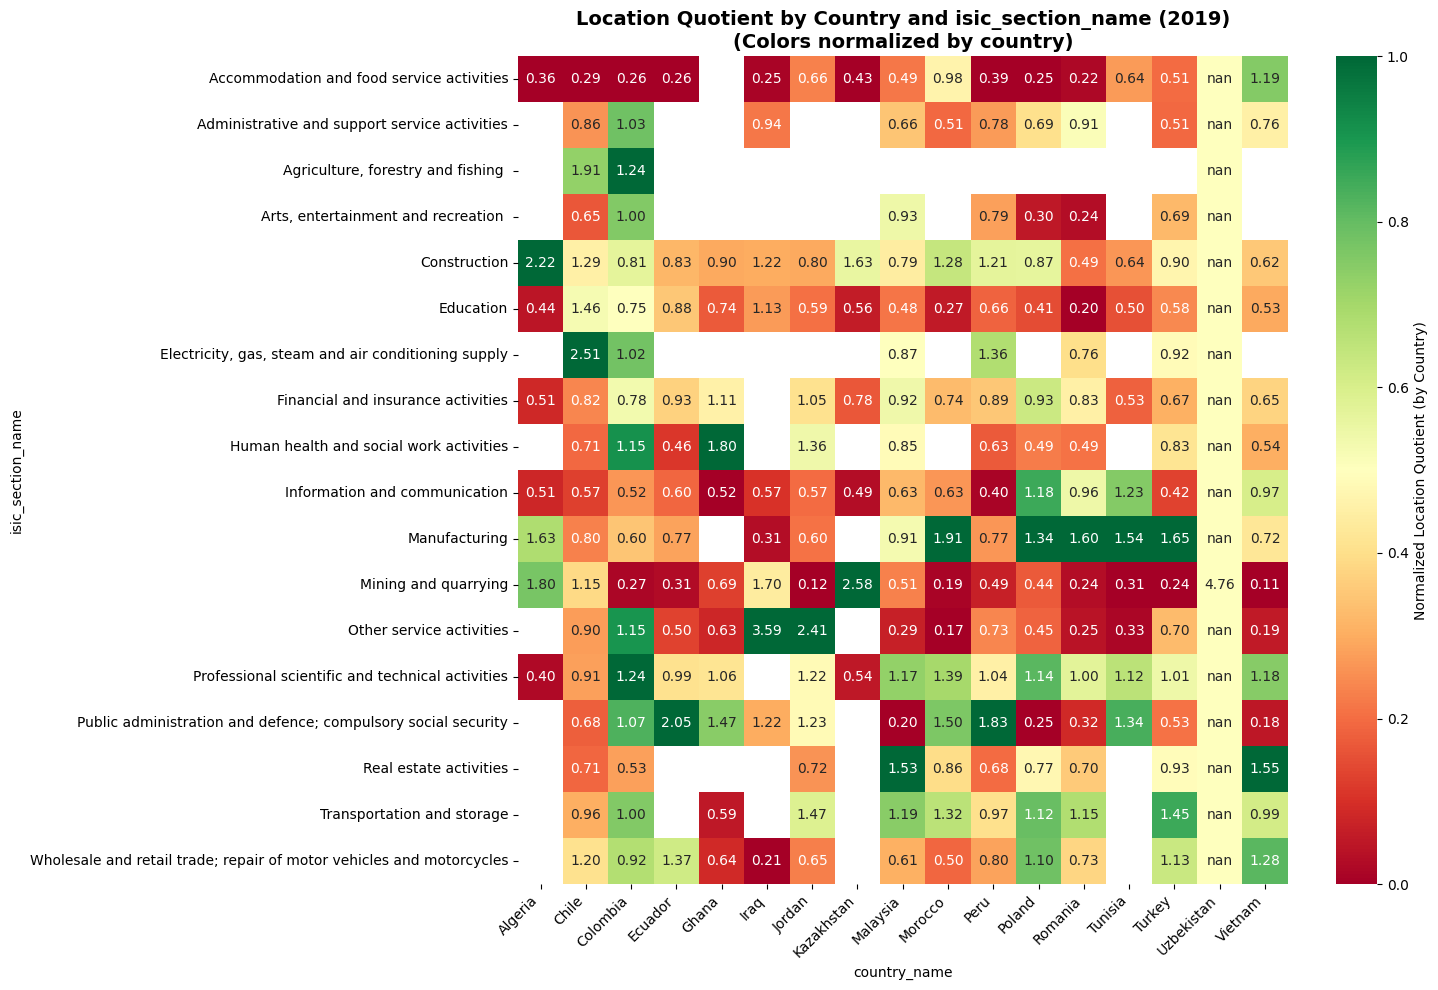

In [193]:
plot_lq_heatmap(lq_section[lq_section['country_name'].isin(countries_of_interest+regional_peers+structural_peers+aspirational_peers)], year=2019)

In [219]:
sections_of_interest = lq_section[(lq_section['country_name']=='Algeria')&(lq_section['lq']>0)]['isic_section_name'].unique().tolist()

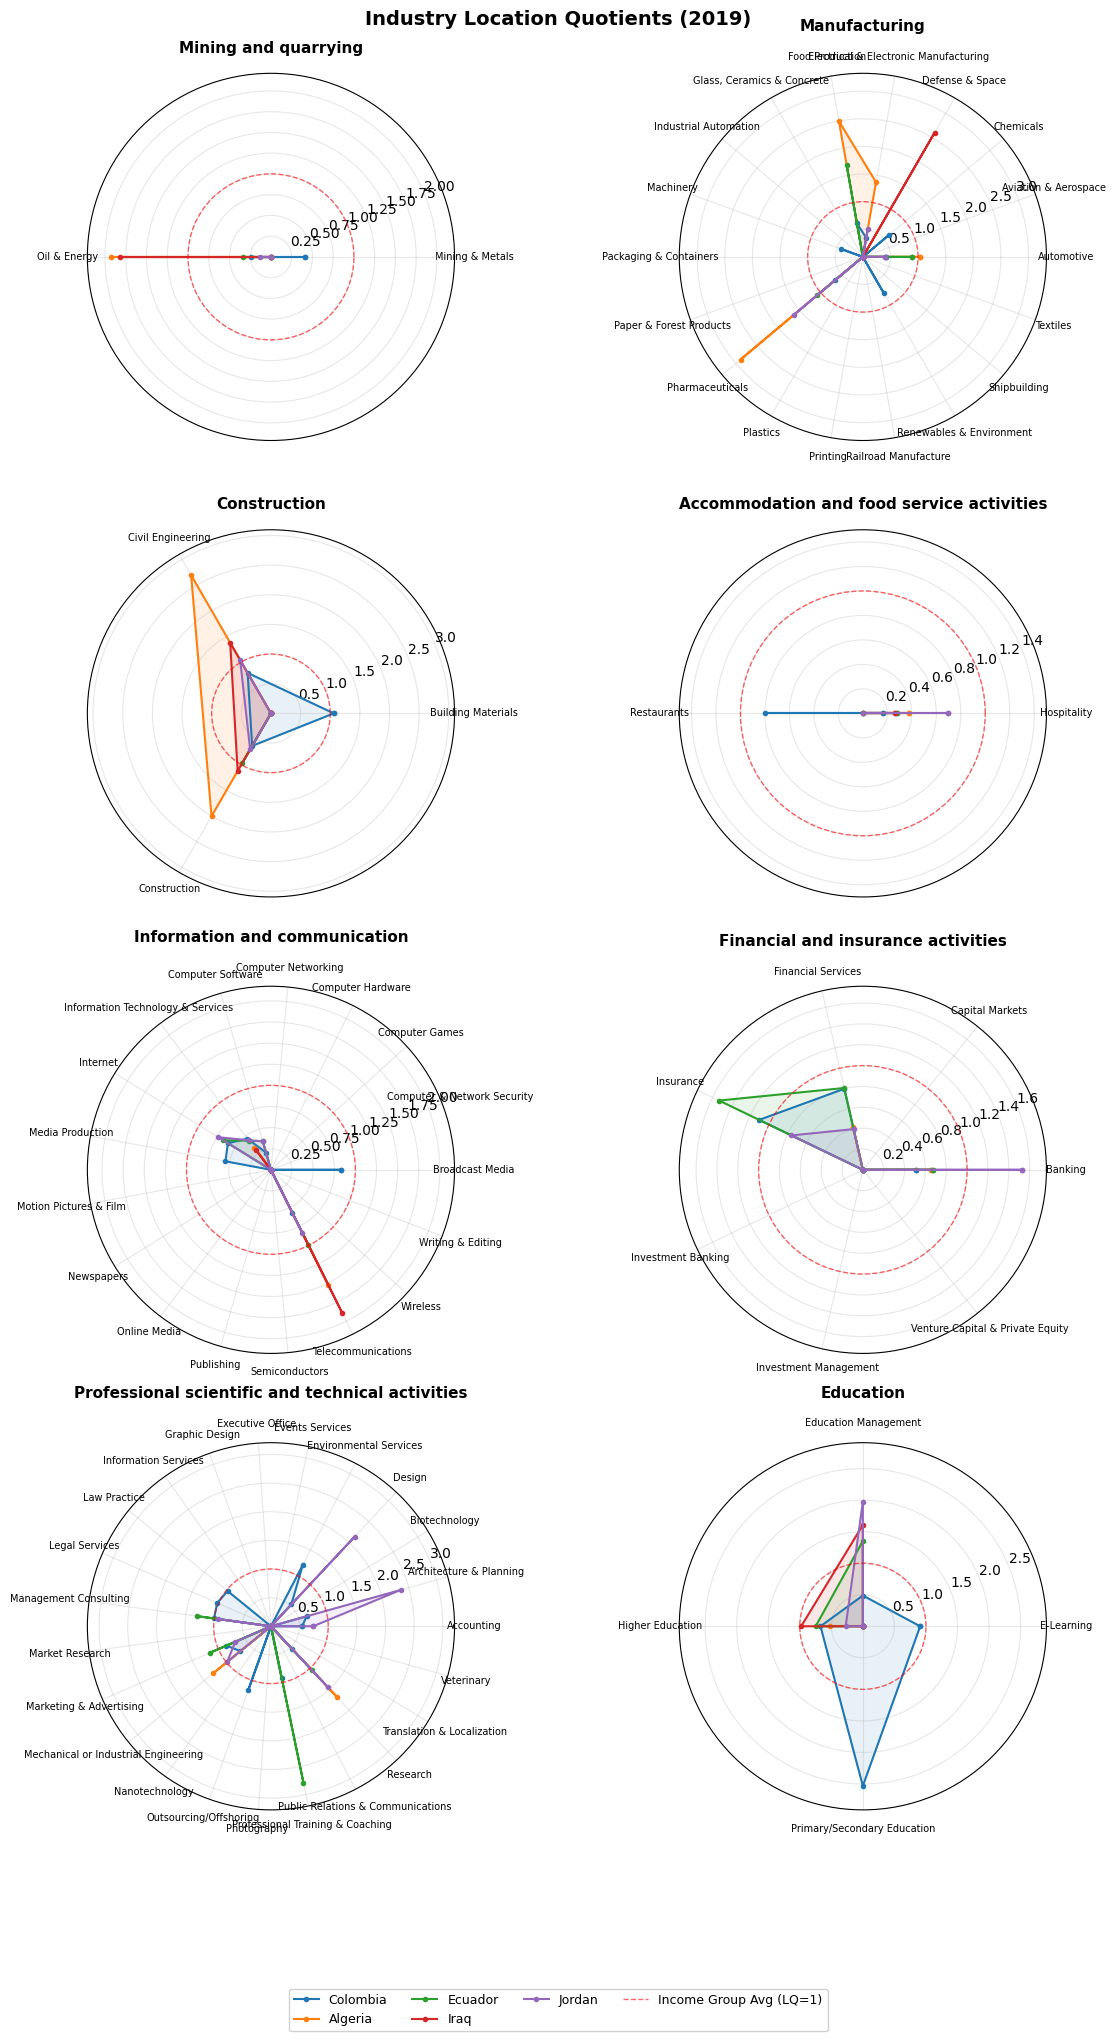

In [224]:
plot_multi_country_radar(lq_industry, peers_in_income_group[0:5], 
                         section_names=sections_of_interest, n_cols=2)


## Country Migration

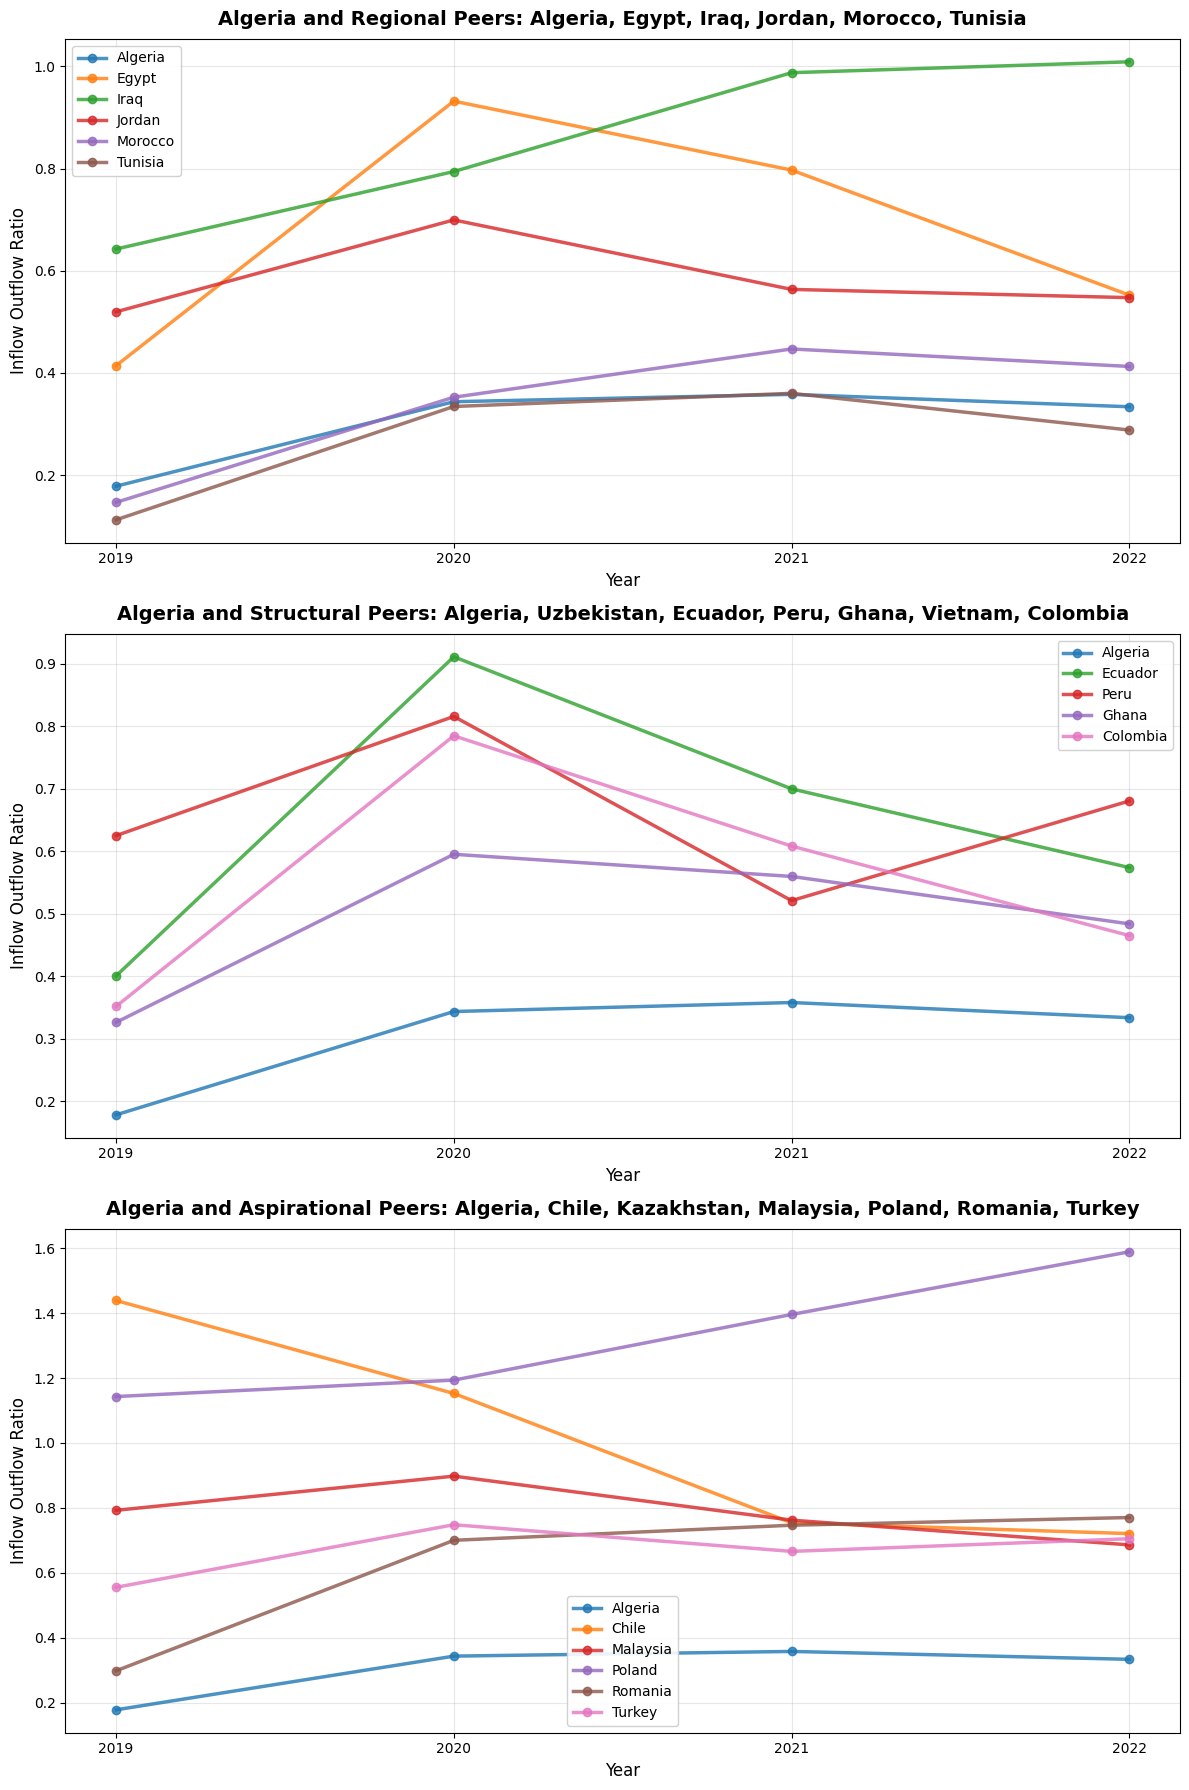

In [206]:
country_flows['year'] = country_flows['year'].astype(str)
performance_tabs = {
    'Algeria and Regional Peers':countries_of_interest + regional_peers,
     'Algeria and Structural Peers':countries_of_interest + structural_peers,
     'Algeria and Aspirational Peers':countries_of_interest + aspirational_peers,
}
plot_matplotlib_custom_tabs(country_flows, performance_tabs, x_col='year', y_col='inflow_outflow_ratio', group_col='country_region')

In [138]:
cm_flow = country_migration[country_migration['base_country_name'].isin(countries_of_interest+regional_peers)][['base_country_name', 'target_country_name',
                                        'inflow_2015', 'outflow_2015', 'grossflow_2015', 'netflow_2015',
       'total_member_cnt_2015', 'net_per_10K_2015', 'inflow_2016',
       'outflow_2016', 'grossflow_2016', 'netflow_2016',
       'total_member_cnt_2016', 'net_per_10K_2016', 'inflow_2017',
       'outflow_2017', 'grossflow_2017', 'netflow_2017',
       'total_member_cnt_2017', 'net_per_10K_2017', 'inflow_2018',
       'outflow_2018', 'grossflow_2018', 'netflow_2018',
       'total_member_cnt_2018', 'net_per_10K_2018', 'inflow_2019',
       'outflow_2019', 'grossflow_2019', 'netflow_2019',
       'total_member_cnt_2019', 'net_per_10K_2019']].groupby('base_country_name')[['inflow_2015', 'outflow_2015', 
                                                                                   'inflow_2016', 'outflow_2016',
                                                                                   'inflow_2017', 'outflow_2017',
                                                                                   'inflow_2018', 'outflow_2018',
                                                                                   'inflow_2019', 'outflow_2019']].sum().reset_index()

In [139]:
def reshape_migration_data_melt(df, id_vars=['base_country_name']):
    """
    Reshape migration data using pandas melt function.
    """
    
    # Melt inflow columns
    inflow_cols = [col for col in df.columns if col.startswith('inflow_')]
    inflow_df = df.melt(
        id_vars=id_vars,
        value_vars=inflow_cols,
        var_name='year_type',
        value_name='inflow'
    )
    inflow_df['year'] = inflow_df['year_type'].str.extract('(\d+)').astype(int)
    inflow_df = inflow_df[id_vars + ['year', 'inflow']]  # Fixed: added id_vars
    
    # Melt outflow columns
    outflow_cols = [col for col in df.columns if col.startswith('outflow_')]
    outflow_df = df.melt(
        id_vars=id_vars,
        value_vars=outflow_cols,
        var_name='year_type',
        value_name='outflow'
    )
    outflow_df['year'] = outflow_df['year_type'].str.extract('(\d+)').astype(int)
    outflow_df = outflow_df[id_vars + ['year', 'outflow']]  # Fixed: consistent with inflow_df
    
    # Merge inflow and outflow data
    result = pd.merge(
        inflow_df, 
        outflow_df, 
        on=id_vars + ['year'],  # Fixed: removed extra space
        how='outer'
    )
    
    return result.sort_values(id_vars + ['year']).reset_index(drop=True)  # Fixed: removed extra space

<>:14: SyntaxWarning: invalid escape sequence '\d'
<>:25: SyntaxWarning: invalid escape sequence '\d'
<>:14: SyntaxWarning: invalid escape sequence '\d'
<>:25: SyntaxWarning: invalid escape sequence '\d'
/var/folders/gs/_227cnyd0pq1fr817_0jbcyw0000gp/T/ipykernel_93902/1954291700.py:14: SyntaxWarning: invalid escape sequence '\d'
  inflow_df['year'] = inflow_df['year_type'].str.extract('(\d+)').astype(int)
/var/folders/gs/_227cnyd0pq1fr817_0jbcyw0000gp/T/ipykernel_93902/1954291700.py:25: SyntaxWarning: invalid escape sequence '\d'
  outflow_df['year'] = outflow_df['year_type'].str.extract('(\d+)').astype(int)


In [140]:
cm_flow = reshape_migration_data_melt(cm_flow)

In [141]:
country_members = country_migration[['base_country_name', 'total_member_cnt_2015', 'total_member_cnt_2016','total_member_cnt_2017','total_member_cnt_2018','total_member_cnt_2019']].drop_duplicates()
member_cols = [col for col in country_members.columns if col.startswith('total_member_cnt_')]
country_members = country_members.melt(
        id_vars=['base_country_name'],
        value_vars=member_cols,
        var_name='year_type',
        value_name='total_members'
    )
country_members['year'] = country_members['year_type'].str.extract('(\d+)').astype(int)
country_members = country_members[['base_country_name', 'year', 'total_members']]

<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
/var/folders/gs/_227cnyd0pq1fr817_0jbcyw0000gp/T/ipykernel_93902/4178178665.py:9: SyntaxWarning: invalid escape sequence '\d'
  country_members['year'] = country_members['year_type'].str.extract('(\d+)').astype(int)


In [142]:
cm_flow['netflow'] = cm_flow['inflow'] - cm_flow['outflow']
cm_flow = cm_flow.merge(country_members, on=['base_country_name', 'year'], how='left')

In [143]:
cm_flow['inflow_per_10K'] = cm_flow['inflow']/(cm_flow['total_members'] / 10000)
cm_flow['outflow_per_10K'] = cm_flow['outflow']/(cm_flow['total_members'] / 10000)
cm_flow['netflow_per_10K'] = cm_flow['netflow']/(cm_flow['total_members'] / 10000)

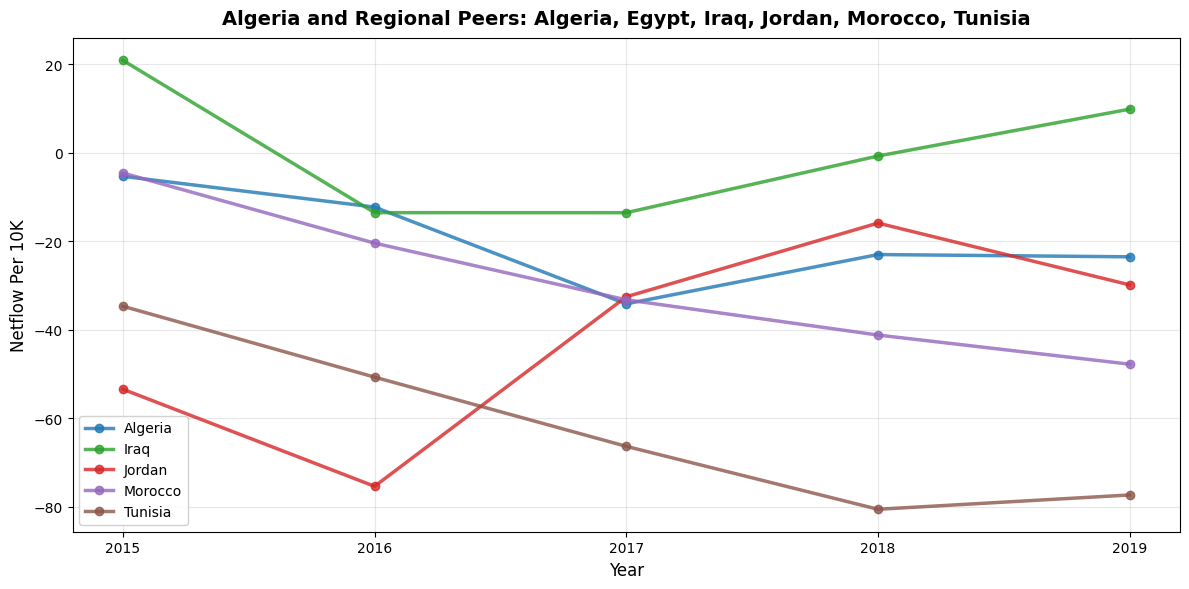

In [198]:
performance_tabs = {
    'Algeria and Regional Peers': countries_of_interest + regional_peers,
    #'Comparative Countries': regional_peers + structural_peers + aspirational_peers,
}
plot_matplotlib_custom_tabs(cm_flow, performance_tabs, x_col='year', y_col='netflow_per_10K', group_col='base_country_name')

In [145]:
pairwise_flows = country_migration[['base_country_name', 'target_country_name','inflow_2015', 'outflow_2015', 
                                    'inflow_2016', 'outflow_2016','inflow_2017', 'outflow_2017','inflow_2018', 'outflow_2018',
                                    'inflow_2019', 'outflow_2019']]
pairwise_flows = reshape_migration_data_melt(pairwise_flows, id_vars=['base_country_name', 'target_country_name'])
pairwise_flows['s2d_d2s_ratio'] = pairwise_flows['outflow'] / pairwise_flows['inflow']

pairwise_flows.rename(columns={'base_country_name': 'source_country_region', 
                                    'target_country_name': 'dest_country_region'}, inplace=True)

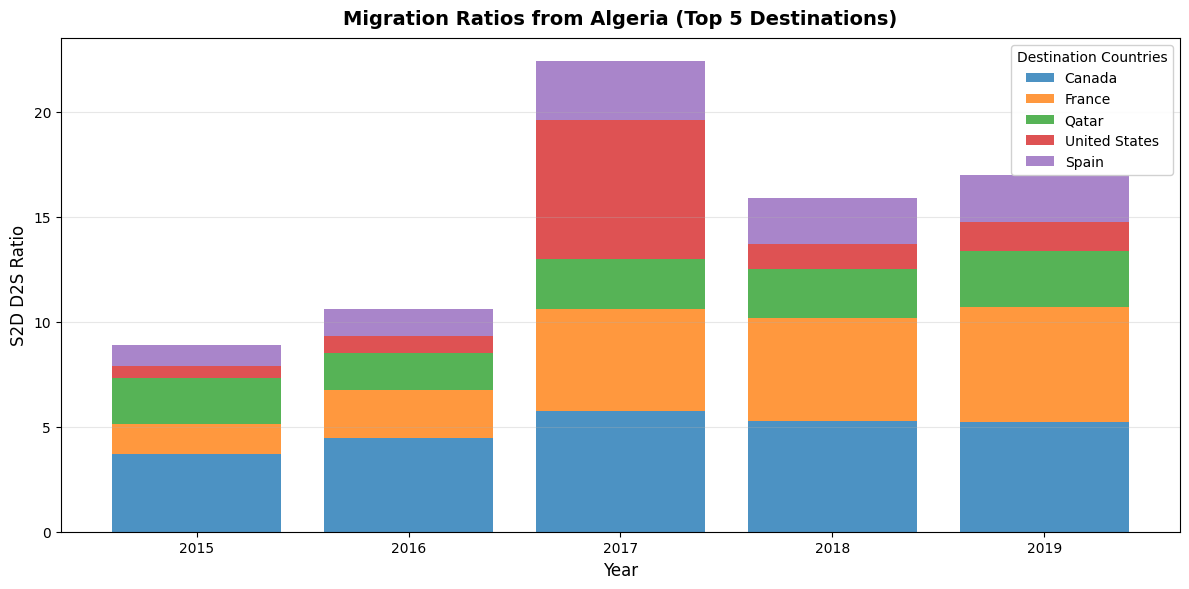

In [205]:
source_countries_list = countries_of_interest

plot_source_country_tabs(pairwise_flows, source_countries_list, metric_col='s2d_d2s_ratio', top_dest_n=5)

## References

Zhu, T. J., Orlowski, J., & Fritzler, A. (2018). World Bank Group-LinkedIn data insights: Jobs, skills and migration trends methodology and validation results. World Bank Group. https://documents1.worldbank.org/curated/en/827991542143093021/pdf/World-Bank-Group-LinkedIn-Data-Insights-Jobs-Skills-and-Migration-Trends-Methodology-and-Validation-Results.pdf